In [16]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import spacy
spacy.cli.download("en_core_web_sm")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re

import emoji


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor
from sklearn import svm


import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold#, GridSearchCV
from sklearn.decomposition import PCA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
nlp = spacy.load("en_core_web_sm")

df_path= "../../scitweets.tsv"
df = pd.read_csv(df_path, sep='\t', header=0)

df = df.drop(columns=[col for col in df.columns if "Unnamed" in col] + ["tweet_id"])
df["text"] = df["text"].astype(str)

In [3]:
class EmojiExtractor(BaseEstimator, TransformerMixin):
	def fit(self, X, y=None):
		return self

	def transform(self, X):
		X = X.copy()

		def count_emojis(text):
			return sum(1 for char in text if char in emoji.EMOJI_DATA)

		def replace_emojis(text):
			return emoji.demojize(text, delimiters=(" ", " "))

		X["emoji_count"] = X["text"].apply(count_emojis)
		X["text"] = X["text"].apply(replace_emojis)

		return X

class LinkExtractor(BaseEstimator, TransformerMixin):
	def fit(self, X, y=None):
		return self

	def transform(self, X):
		X = X.copy()

		def count_links(text):
			return len(re.findall(r'https?:\/\/.*[\r\n]*', text))

		def remove_links(text):
			return re.sub(r'https?:\/\/\S+', '[url]', text)

		X["link_count"] = X["text"].apply(count_links)
		X["text"] = X["text"].apply(remove_links)

		return X
	
class TextPreprocessor(BaseEstimator, TransformerMixin):
	def fit(self, X, y=None):
		return self

	def transform(self, X):
		X = X.copy()
		def preprocess(text):
			doc = nlp(text.lower())
			return " ".join(token.lemma_ for token in doc if not token.is_stop and not token.is_punct)

		X["text"] = X["text"].apply(preprocess)
		return X

## Define the pipeline for the model

In [4]:
X = df.copy().drop(columns=["scientific_claim", "scientific_reference", "scientific_context"])
y = X.pop("science_related")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size=0.2)
pd.set_option('display.max_colwidth', 110)
X_train.head()

,text
938,.@Frontier_Usyd is hosting a Frontotemporal Dementia (FTD) Information & Support Day for Families and Care...
470,If only people would stop interfering in other people's business 😜😜😜😜😜😜😜😜
326,when will the underwear stop flying
406,@martinhanratty @AtyHans @thenotimer I listened to a gospel radio station for a couple of hours--the confi...
953,when truth untold stops playing and the lights turn green.... https://t.co/lBFhLHyUbn


In [5]:
def display_result(predicted_y, true_y ):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    cm = confusion_matrix(true_y, predicted_y)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non science related", "Science related"],
            yticklabels=["Non science related", "Science related"], ax=axes[0])

    axes[0].set_xlabel("Predicted Label")
    axes[0].set_ylabel("True Label")
    axes[0].set_title("Confusion Matrix")

    target_names = ['Non science related', 'Science related']
    class_report = classification_report(true_y, predicted_y, labels=[0, 1], target_names=target_names)

    axes[1].text(0, 0.5, class_report, fontsize=12, family='monospace')
    axes[1].axis("off")
    axes[1].set_title("Classification Report")

    plt.tight_layout()
    plt.show()

In [6]:
column_transformer = ColumnTransformer([
    ("tfidf", TfidfVectorizer(stop_words='english', ngram_range=(1,4)), "text"),
    ("pass_features", "passthrough", ["emoji_count", "link_count"])
])


def getPipeline(model):
    return Pipeline([
        ("emoji_processing", EmojiExtractor()),
        ("link_processing", LinkExtractor()),
        ("text_processing", TextPreprocessor()),
        ("feature_vectorizer", column_transformer),
        ("classifier", model)
        #("classifier", svm.SVC(kernel='linear', class_weight='balanced'))
        #("classifier", RandomForestClassifier(random_state = 1))
        #("classifier", XGBRegressor( random_state=1))
    ])

In [7]:
def objective(trial):
  C = trial.suggest_loguniform('C', 1, 10.0)

  kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
  gamma = trial.suggest_loguniform('gamma', 7, 10.0) if kernel == 'rbf' else 'scale'
  model = svm.SVC(C=C, kernel=kernel, gamma=gamma, random_state=1, class_weight='balanced')

  pipeline = getPipeline(model)

  kfold = KFold(n_splits=3, random_state=1, shuffle=True)
  score = cross_val_score(pipeline, X=X_train, y=y_train,  cv=kfold, scoring='f1_macro').mean()

  return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4)

[I 2025-05-01 13:25:52,972] A new study created in memory with name: no-name-937213c1-b13b-47e5-808a-31507f5355a6
/tmp/ipykernel_38142/2088243869.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1, 10.0)
[I 2025-05-01 13:26:18,041] Trial 0 finished with value: 0.7767577751058226 and parameters: {'C': 4.388334915917872, 'kernel': 'linear'}. Best is trial 0 with value: 0.7767577751058226.
/tmp/ipykernel_38142/2088243869.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1, 10.0)
[I 2025-05-01 13:26:44,779] Trial 1 finished with value: 0.7888214645047252 and parameters: {'C': 1.113682703262076, 'kernel

In [8]:
print("Meilleurs hyperparamètres :")
print(study.best_params)
print(f"Meilleur score : {study.best_value:.3f}")


Meilleurs hyperparamètres :
{'C': 1.0530517569257107, 'kernel': 'linear'}
Meilleur score : 0.790


In [9]:
model = svm. SVC(
  C=study.best_params['C'],
  kernel=study.best_params['kernel'],
  random_state=1,
  class_weight='balanced'
  )
pipeline = getPipeline(model)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('emoji_processing', EmojiExtractor()),
                ('link_processing', LinkExtractor()),
                ('text_processing', TextPreprocessor()),
                ('feature_vectorizer',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               4),
                                                                  stop_words='english'),
                                                  'text'),
                                                 ('pass_features',
                                                  'passthrough',
                                                  ['emoji_count',
                                                   'link_count'])])),
                ('classifier',
                 SVC(C=1.0530517569257107, class_weight='balanced',
                     kernel='linear', random_state=1))])

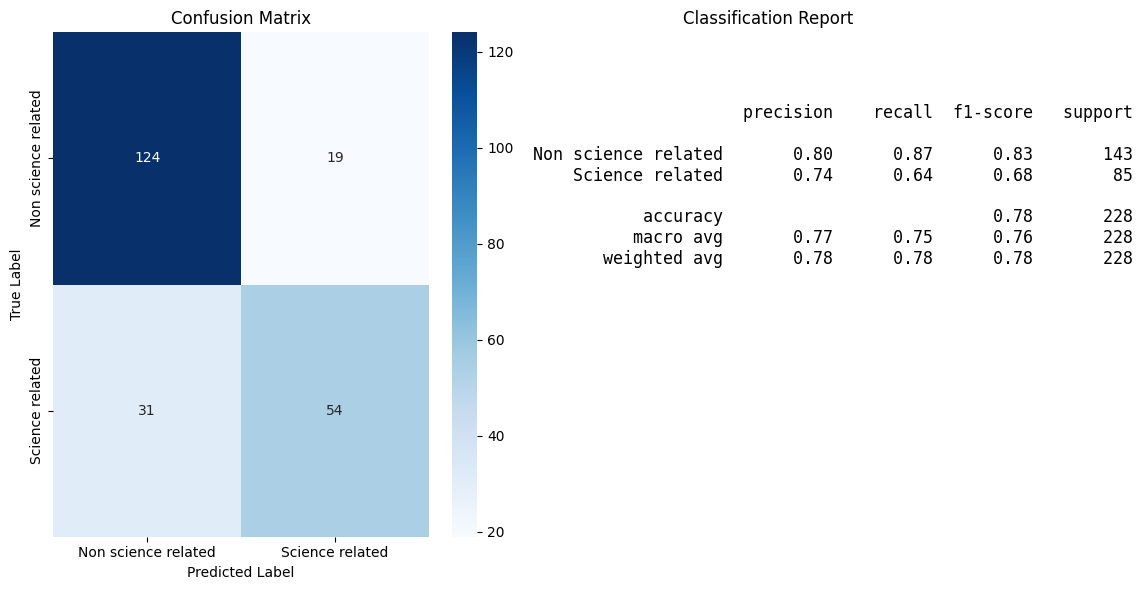

In [10]:
predictions = pipeline.predict(X_test)
display_result(predictions, y_test )

In [11]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=1,
        class_weight='balanced'
    )

    pipeline = getPipeline(model)

    kfold = KFold(n_splits=3, random_state=1, shuffle=True)
    score = cross_val_score(pipeline, X=X_train, y=y_train, cv=kfold, scoring='f1_macro').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=6)

[I 2025-05-01 13:27:57,447] A new study created in memory with name: no-name-68646c2d-c017-4eac-ad04-2c3fb5f34262
[I 2025-05-01 13:28:22,984] Trial 0 finished with value: 0.6379818496597749 and parameters: {'n_estimators': 56, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6379818496597749.
[I 2025-05-01 13:28:46,208] Trial 1 finished with value: 0.7593052744088354 and parameters: {'n_estimators': 286, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7593052744088354.
[I 2025-05-01 13:29:18,044] Trial 2 finished with value: 0.7408925652707773 and parameters: {'n_estimators': 212, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7593052744088354.
[I 2025-05-01 13:29:43,241] Trial 3 finished with value: 0.6471092964986839 and parameters: {'n_estimators': 221, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0

In [12]:
model = RandomForestClassifier(
        n_estimators=study.best_params['n_estimators'],
        max_depth=study.best_params['max_depth'],
        min_samples_split=study.best_params['min_samples_split'],
        min_samples_leaf=study.best_params['min_samples_leaf'],
        random_state=1,
        class_weight='balanced'
    )
pipeline = getPipeline(model)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('emoji_processing', EmojiExtractor()),
                ('link_processing', LinkExtractor()),
                ('text_processing', TextPreprocessor()),
                ('feature_vectorizer',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               4),
                                                                  stop_words='english'),
                                                  'text'),
                                                 ('pass_features',
                                                  'passthrough',
                                                  ['emoji_count',
                                                   'link_count'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=18,
                                        min_samples_leaf=3, min_samples_split=7,
                                        n_estimators=238, random_state=1))])

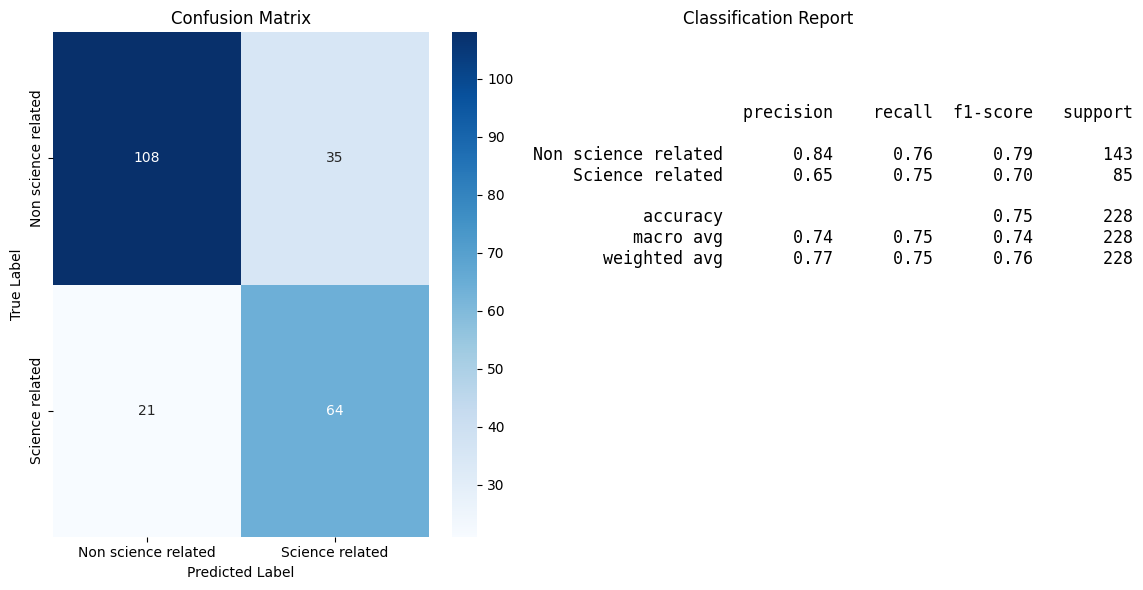

In [13]:
predictions = pipeline.predict(X_test)
display_result(predictions, y_test )

In [14]:
misclassified_indices = np.where(predictions != y_test)[0]

# Récupérer les tweets mal classifiés
misclassified_tweets = X_test.iloc[misclassified_indices]['text'].tolist()
misclassified_true = y_test.iloc[misclassified_indices].tolist()
misclassified_pred = predictions[misclassified_indices].tolist()

misclassified_df = pd.DataFrame({
    'tweet': misclassified_tweets,
    'true_label': misclassified_true,
    'predicted_label': misclassified_pred
})
misclassified_df.head(20)

,tweet,true_label,predicted_label
0,Overthinking leads to negative thoughts.,1,0
1,Check out B HEALING STONE & MAGNET PILLOW (THERPIC)HELPS STOP PAIN IN THE BODY http://t.co/3V9oG2aeHV via ...,1,0
2,Asymmetrical matter https://t.co/d60QDEph8k #science https://t.co/Kerl7vCj1j,0,1
3,"Turkey reports lower number of coronavirus cases for a second day in row. 4,093 cases were reported Monday...",1,0
4,Tomato Planting Tips That Lead To Healthy Tomato Plants https://t.co/AGMz3vuEFA,0,1
5,Have you saw it before? The production process of general Diodes / fast recover rectifier. etc. https://t....,0,1
6,5 Surprising Ways Social Media is Affecting Healthcare ~ Social Media Frontiers: http://t.co/IxuQ4hfxw5,1,0
7,Q: Is there a connection between shellfish allergies and iodine? - Wilderness Medical Associates Internati...,1,0
8,Why female alcoholism is a time bomb https://t.co/QmPtMXrSJS via @BBC_Future,1,0
9,Three systematic reviews & the WHO contradict the claims in this thread https://t.co/wOGfvARgx5 & https://...,1,0


In [15]:
tfidf_vectorizer = pipeline.named_steps['feature_vectorizer'].named_transformers_['tfidf']

feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_matrix = tfidf_vectorizer.transform(X['text'])
feature_scores = np.asarray(tfidf_matrix.sum(axis=0)).ravel()

feature_df = pd.DataFrame({'word': feature_names, 'tfidf_score': feature_scores})

feature_df.sort_values(by='tfidf_score', ascending=False).head(20)


,word,tfidf_score
26311,stop,27.993870
27253,support,18.542632
20101,people,11.700866
18477,new,8.958892
8163,don,8.204143
4465,cause,8.000100
13423,increase,7.696767
24436,science,7.641193
11359,good,6.630857
15591,life,6.327495


In [17]:
reducer = PCA(n_components=2)

# Option B: t-SNE (slower, non-linear)
# reducer = TSNE(n_components=2, random_state=42)

X_reduced = reducer.fit_transform(tfidf_vectorizer.toarray())

AttributeError: 'TfidfVectorizer' object has no attribute 'toarray'

In [ ]:
df_plot = pd.DataFrame()
df_plot['x'] = X_reduced[:, 0]
df_plot['y'] = X_reduced[:, 1]
df_plot['label'] = y

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette='tab10', s=60)
plt.title('TF-IDF + Dimensionality Reduction (PCA/t-SNE)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Class')
plt.grid(True)
plt.tight_layout()
plt.show()